# User W2V Similarities Notebook
## Imports

In [1]:
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import numpy as np
from matplotlib import pyplot as plt

## Loading the dataset

In [2]:
#open csv's and join into one variable p
p1 = pd.read_csv("../input/Postings_01052019_15052019.csv", delimiter=";")
p2 = pd.read_csv("../input/Postings_16052019_31052019.csv", delimiter=";")
p = pd.concat([p1, p2])
p = p.reset_index()
p = p.drop(["index"], axis=1)

## Opening the preprocessed vectors.pkl file

File was generated by the "make_w2v_pickle.py" file. Follow code and comments in that file in order to understand how this file was generated.

In [3]:
#open w2v embeddings pickles
w2vs = []
for i in range(9): #amount of vector_*.pkl files is hardcoded here!
    w2vs.append(pd.read_pickle(r'w2v/vectors_'+str(i)+'.pkl'))
w2v = pd.concat(w2vs)

## Preparing functions to use for user similarity comparison

Comments at the beginnings of the code chunks explain functionality

In [4]:
#given a sentenct/paragraph/collection of words it returns the mean of the w2v weights
#these words need to be normalized which text_to_vector() does before calling this function
def get_w2v_averages(words):
    return w2v[w2v[0].isin(words)].iloc[:,1:].mean()

In [5]:
#splits up the dataset in df equal groups and creates a new column (named 0) assigning distinct numbers to each of the groups so it's possible to perform group operations afterwards
def equal_groups(df, chunks):
    amount_rows = df.shape[0]
    chunks = pd.Series(range(amount_rows)).apply(lambda x: int(x/(amount_rows/chunks)))
    chunks.index = df.index
    return pd.concat([chunks,df],axis=1)

In [6]:
#return averaged w2v from given sentence
def text_to_vector(text):
    text = text.lower() #lowercase words, all words in w2v dictionary are lowercase
    tokens = RegexpTokenizer(r'\w+').tokenize(text)
    tokens = [t for t in tokens if not t in stopwords.words('german')]
    return get_w2v_averages(tokens)

In [7]:
#given the dataset two users, and a chunk size, returns similarities
def w2v_similarities(user1, user2, chunks=1, df=p):
    df = equal_groups(p, chunks)
    vecs1 = get_user_vectors(df, user1)
    vecs2 = get_user_vectors(df, user2)
    return (np.dot(vecs1,vecs2.transpose())/(np.linalg.norm(vecs1, axis=1)*np.linalg.norm(vecs2, axis=1))).diagonal() #cosine similarity

In [8]:
#returns all vectors from the users. equal_groups(df, chunks) is expected as input for "df" here.
def get_user_vectors(df, userid):
    chunksize = df.tail(1)[0].iloc[0] + 1
    filtered = df[df["ID_CommunityIdentity"] == userid].fillna("")
    vectors = (filtered["PostingHeadline"] + " " + filtered["PostingComment"]).apply(lambda x: text_to_vector(x))
    grouped_vectors = equal_groups(vectors, chunksize).groupby([0]).mean()
    return grouped_vectors.reindex(index = np.arange(0,chunksize), method="ffill")

In [9]:
def plot_user_similarities(user1, user2, chunksize, df=p):
    fig, ax = plt.subplots()
    ax.plot(np.linspace(0,df.shape[0], chunksize), w2v_similarities(user1, user2, chunksize, df))
    ax.set_xlabel("Position in original dataset")
    ax.set_ylabel("Cosine similarity")
    ax.set_title("Cosine similarities, users "+ str(user1) +" and "+ str(user2) +", " + str(chunksize) + " chunks")

# Use Cases 

What you can do with after running the code chunks above.

## UC1: Get overall similarity between two users

In [10]:
w2v_similarities(669286, 566938)

array([0.978363])

## UC2: Get similarity between two users over time

Code calculates the embeddings for both users, splits original df into n equal sized parts, groups over these parts and calculates the similarities of the averaged vectors for each of the users for the given chunks.

In [11]:
w2v_similarities(669286, 566938, 30)

array([0.69549806, 0.91433492, 0.84075305, 0.83503591, 0.76298184,
       0.90414199, 0.7604295 , 0.75103255, 0.61460168, 0.93842824,
       0.73954362, 0.77387134, 0.4435356 , 0.82870473, 0.6404681 ,
       0.89897639, 0.95999603, 0.83829174, 0.64854257, 0.91754828,
       0.90200532, 0.79525704, 0.71836956, 0.74653632, 0.88445482,
       0.8589613 , 0.90812131, 0.93066077, 0.88500112, 0.90656763])

## UC3: Plot similarity between two users over time

### 30 chunks, 20 chunks, and 10 chunks as an example

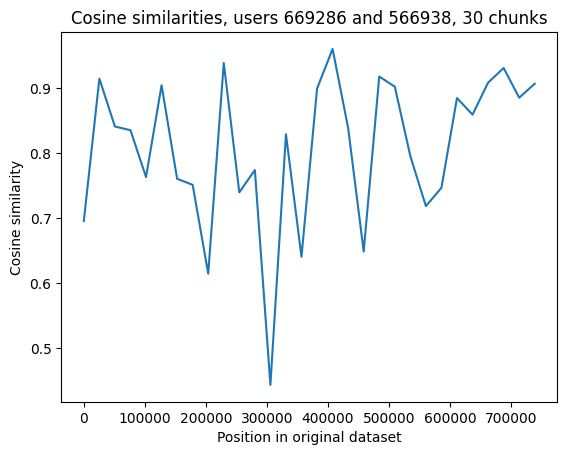

In [12]:
plot_user_similarities(669286, 566938, 30)

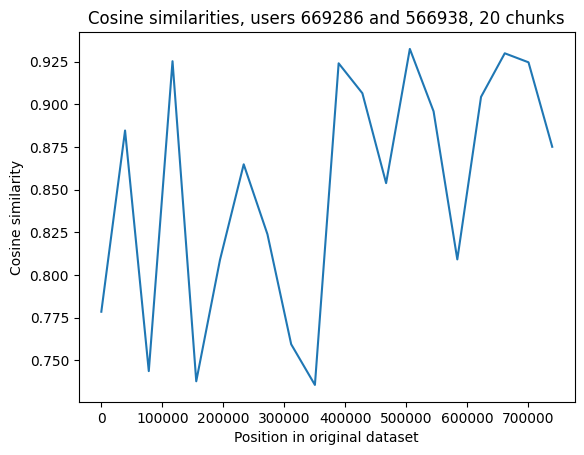

In [13]:
plot_user_similarities(669286, 566938, 20)

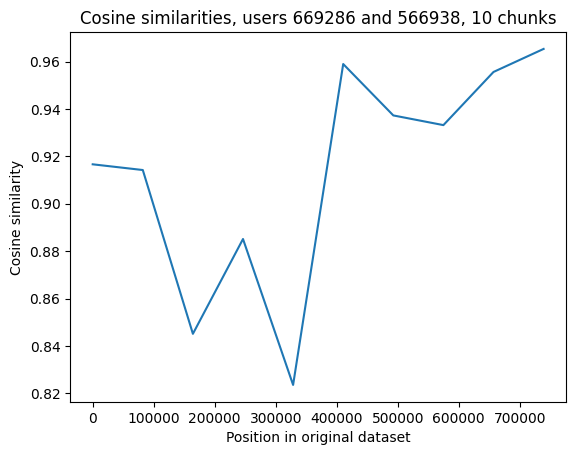

In [14]:
plot_user_similarities(669286, 566938, 10)

Interesting finding: The smaller you pick the window size, the higher the similarity number. This may be explained by the fact that two users may not talk about the same things every day. Considering more comments, the topics two users talk about may be more balanced and in summary, more similar.